<a href="https://colab.research.google.com/github/annisajumalia/202055202012-annisa/blob/master/penyakitdaun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.optimizers
import tensorflow as tf

import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import accuracy_score, classification_report

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data = pd.read_csv("/content/drive/MyDrive/dataset/dataset-jagung/data-excel/PenyakitDaunJagung.csv")
data.head()

,image,labels,Hawar Daun,Bercak Daun,Karatan Daun
0,Hawar&Karat&karatan-65.jpg,"['Hawar Daun', 'Bercak Daun', 'Karatan Daun']",1,1,1
1,bercak-309.jpg,['Bercak Daun'],0,1,0
2,hawar-46.jpg,['Hawar Daun'],1,0,0
3,Bercak&Karatan-9.jpg,"['Bercak Daun', 'Karatan Daun']",0,1,1
4,karatan-190.jpg,['Karatan Daun'],0,0,1


In [10]:
data = data[:1405]
len(data)

1405

In [11]:
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from PIL import ImageFile
import numpy as np

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

image_size = 150
image_list = []
invalid_images = []

# Loop through the dataset and load images
for i in tqdm(range(data.shape[0])):
    try:
        img = image.load_img('/content/drive/MyDrive/dataset/dataset-jagung/images/' + data['image'][i], target_size=(image_size, image_size, 3))
        img = image.img_to_array(img)
        img = img / 255.0
        image_list.append(img)
    except (OSError, ValueError) as e:
        print(f"Error loading image {data['image'][i]}: {e}")
        invalid_images.append(i)

# Remove invalid images from the DataFrame
data = data.drop(invalid_images).reset_index(drop=True)

# Convert the list of images to a NumPy array
X = np.array(image_list)

100%|██████████| 1405/1405 [14:28<00:00,  1.62it/s]


In [12]:
image_list = np.array(image_list)
print(image_list)

[[[[0.40392157 0.47058824 0.20392157]
   [0.53333336 0.54901963 0.2509804 ]
   [0.43529412 0.4627451  0.16078432]
   ...
   [0.8627451  0.8666667  0.88235295]
   [0.84313726 0.84705883 0.8627451 ]
   [0.83137256 0.8352941  0.8509804 ]]

  [[0.35686275 0.41568628 0.16078432]
   [0.30980393 0.38431373 0.13333334]
   [0.3254902  0.39215687 0.11372549]
   ...
   [0.8666667  0.87058824 0.8862745 ]
   [0.8392157  0.84313726 0.85882354]
   [0.8509804  0.8666667  0.8784314 ]]

  [[0.67058825 0.6039216  0.33333334]
   [0.5764706  0.49019608 0.20392157]
   [0.64705884 0.5764706  0.28627452]
   ...
   [0.83137256 0.8352941  0.8509804 ]
   [0.83137256 0.8352941  0.85490197]
   [0.87058824 0.8745098  0.8901961 ]]

  ...

  [[0.40784314 0.6392157  0.79607844]
   [0.38039216 0.5647059  0.7294118 ]
   [0.14509805 0.28235295 0.39215687]
   ...
   [0.4745098  0.5058824  0.27450982]
   [0.40784314 0.4509804  0.22352941]
   [0.36078432 0.4        0.16470589]]

  [[0.36862746 0.60784316 0.7921569 ]
   [0.3

In [13]:
#Categorical Data
y = data[['Hawar Daun', 'Bercak Daun', 'Karatan Daun']].values
y

array([[1, 1, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [1, 1, 1]])

In [14]:
x_train, x_testval, y_train, y_testval = train_test_split(image_list, y, test_size=0.2, random_state=42) #80% Train, 10% Validation, 10% Test
x_val, x_test, y_val, y_test = train_test_split(x_testval, y_testval, test_size=0.5, random_state=42)

In [15]:
import keras
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
# Tambahkan lapisan tambahan ke model base Anda
x = GlobalAveragePooling2D()(model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='sigmoid')(x)

In [18]:
model = keras.models.Model(inputs=model.input, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,074,275 (84.21 MB)

 Trainable params: 22,039,459 (84.07 MB)

 Non-trainable params: 34,816 (136.00 KB)

In [19]:
# optimizer = keras.optimizers.Adam(learning_rate=0.0001)

# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Tambahkan callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [20]:
# history = model.fit(x_train,
#                     y_train,
#                     epochs=20,
#                     batch_size=64,
#                     validation_data=(x_val, y_val)
#                     )

# Train model
history = model.fit(x_train,
                          y_train,
                          epochs=20,
                          batch_size=64,
                          validation_data=(x_val, y_val),
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 287s 13s/step - accuracy: 0.5025 - loss: 0.6612 - val_accuracy: 0.4786 - val_loss: 4.6116 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 257s 13s/step - accuracy: 0.7109 - loss: 0.2984 - val_accuracy: 0.4786 - val_loss: 4.2449 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 257s 12s/step - accuracy: 0.7688 - loss: 0.2106 - val_accuracy: 0.4786 - val_loss: 1.5624 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 259s 12s/step - accuracy: 0.7892 - loss: 0.1552 - val_accuracy: 0.4857 - val_loss: 1.0749 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 266s 12s/step - accuracy: 0.7804 - loss: 0.1194 - val_accuracy: 0.6571 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 267s 13s/step - accuracy: 0.8253 - loss: 0.0916 - val_accuracy: 0.8357 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 256s 12s/step - accuracy: 0.8106 - loss: 0.0864 - 

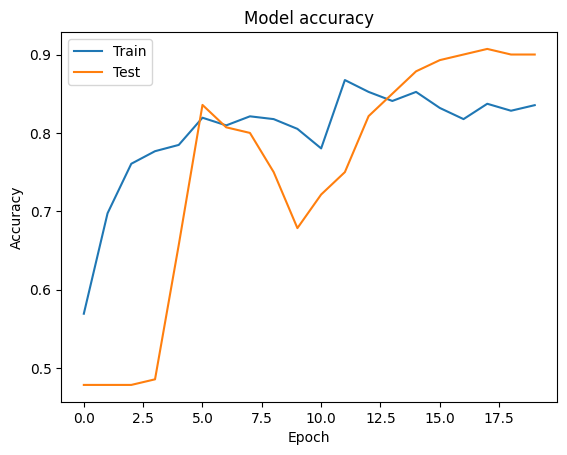

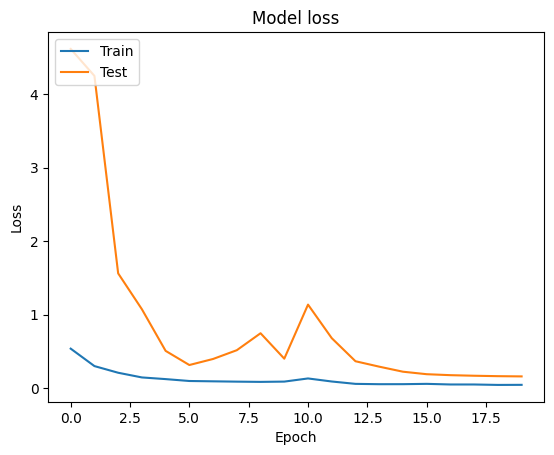

In [21]:
# prompt: tampilkan # Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Accuracy: 0.9219858156028369
              precision    recall  f1-score   support

  Hawar Daun       0.97      0.97      0.97        66
 Bercak Daun       0.97      0.91      0.94        69
Karatan Daun       0.92      0.97      0.94        67

   micro avg       0.95      0.95      0.95       202
   macro avg       0.95      0.95      0.95       202
weighted avg       0.95      0.95      0.95       202
 samples avg       0.94      0.94      0.93       202



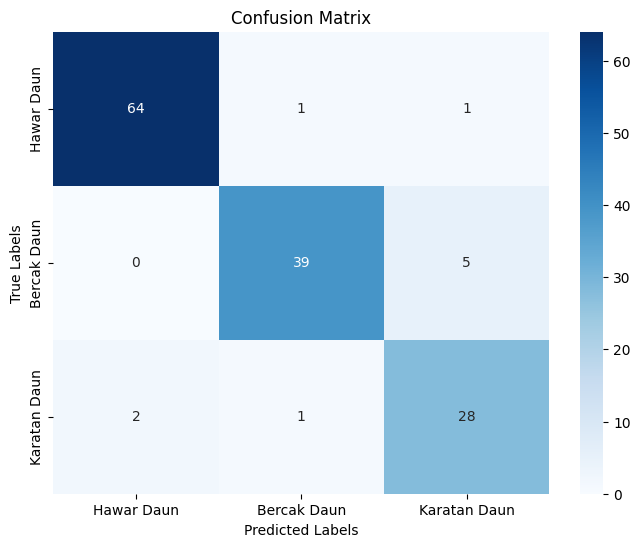

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Asumsikan x_test dan y_test sudah tersedia

# Evaluasi model pada test set
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Konversi probabilitas menjadi label kelas

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# Buat laporan klasifikasi
print(classification_report(y_test, y_pred_classes, target_names=['Hawar Daun', 'Bercak Daun', 'Karatan Daun']))

# Buat confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Hawar Daun', 'Bercak Daun', 'Karatan Daun'], yticklabels=['Hawar Daun', 'Bercak Daun', 'Karatan Daun'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Simpan Model Tflite
# Menyimpan model dalam format tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model tflite ke file
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp3iw_h41v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140520287695312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520287694352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520287696656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520287696464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520287695888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520287695504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520287696848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520287694736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520287695120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140520308584912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14052030858625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Hawar Daun: 99.90%
Bercak Daun: 99.79%
Karatan Daun: 99.27%


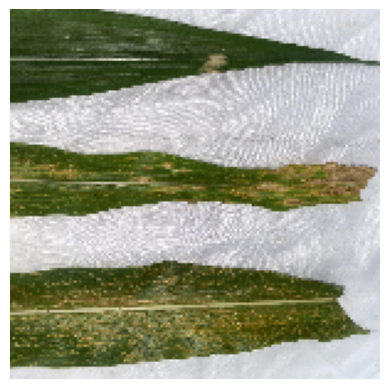

In [24]:
# Load dan preprocess gambar
img_path = '/content/drive/MyDrive/dataset/dataset-jagung/Hawar&Karat&karatan/Hawar&Karat&karatan-103.jpg'
img = image.load_img(img_path, target_size=(image_size, image_size))
img = image.img_to_array(img)
img = img / 255.0

# Prediksi
proba = model.predict(img.reshape(1, image_size, image_size, 3))
threshold = 0.5  # Set threshold
classes = np.array(['Hawar Daun', 'Bercak Daun', 'Karatan Daun'])  # Gantilah sesuai dengan kelas Anda

# Terapkan threshold
top_classes = [classes[i] for i in range(len(proba[0])) if proba[0][i] > threshold]
top_proba = [proba[0][i] for i in range(len(proba[0])) if proba[0][i] > threshold]

# Logika untuk menangani gambar di luar dataset
if not top_classes:
    print("Gambar tidak termasuk dalam dataset yang dikenal")
else:
    for i in range(len(top_classes)):
        print(f"{top_classes[i]}: {top_proba[i]*100:.2f}%")

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')  # Sembunyikan sumbu
plt.show()

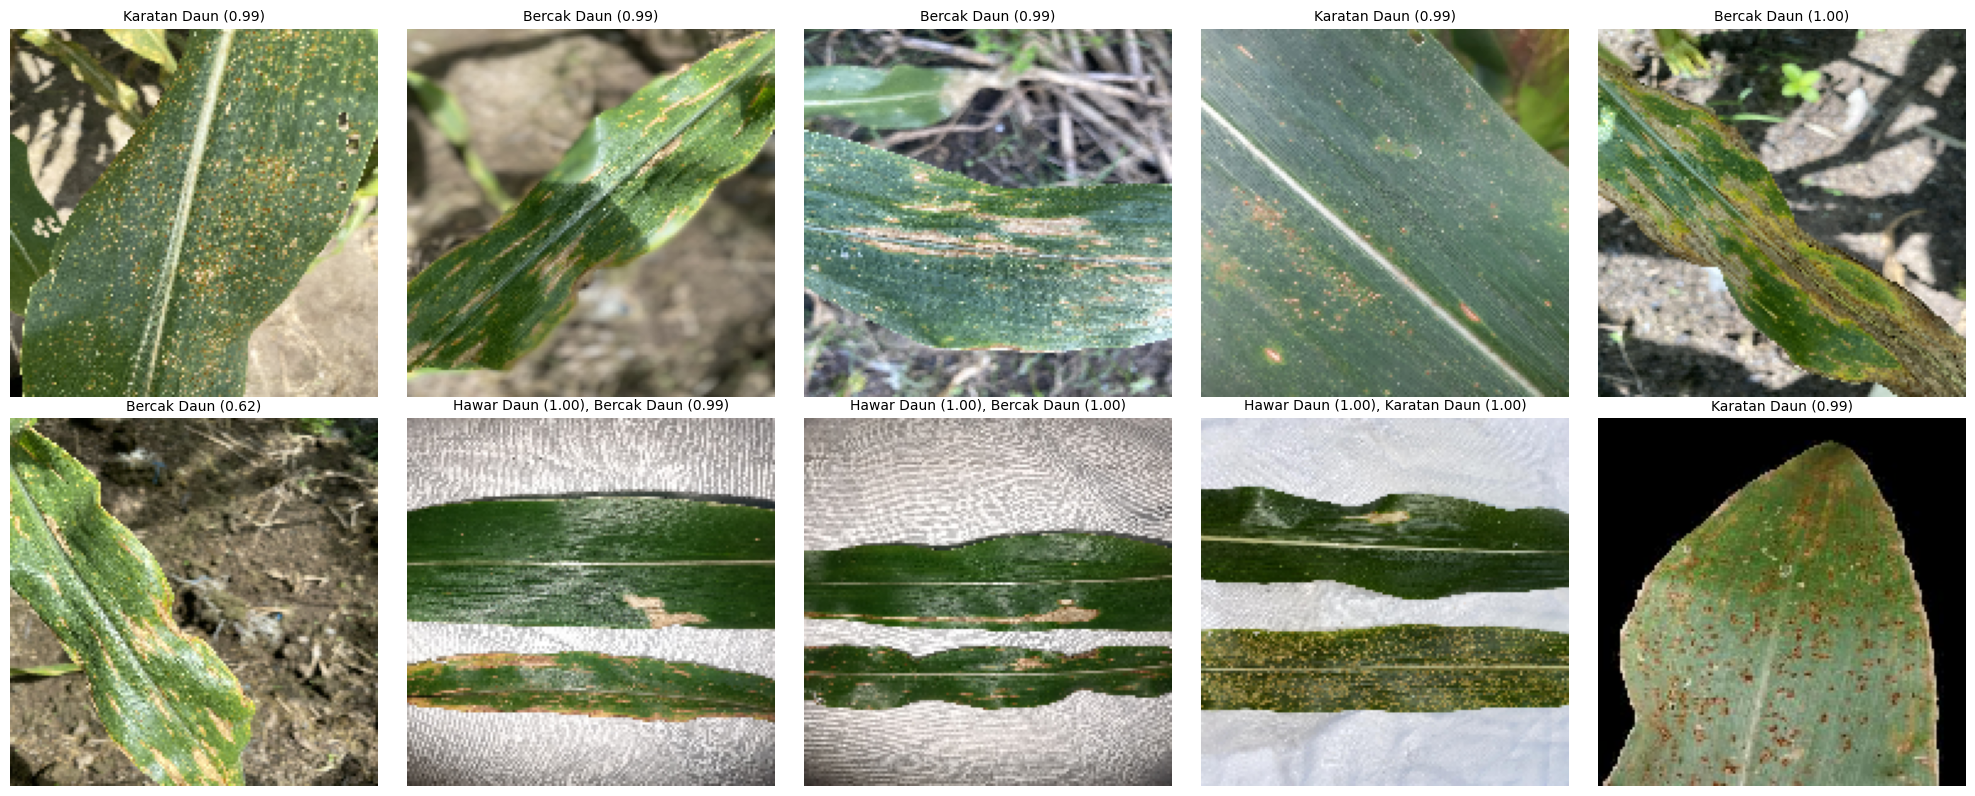

In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import random

# Muat model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Dapatkan input dan output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Path dataset dan ambil daftar file gambar dari semua subfolder
dataset_path = '/content/drive/MyDrive/dataset/dataset-jagung/'
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

# Pilih 10 gambar secara acak
sample_files = random.sample(image_files, 10)

# Fungsi untuk memproses gambar dan melakukan prediksi
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(image_size, image_size))
    img = image.img_to_array(img)
    img = img / 255.0

    # Predict
    interpreter.set_tensor(input_details[0]['index'], img.reshape(1, image_size, image_size, 3).astype(np.float32))
    interpreter.invoke()
    proba = interpreter.get_tensor(output_details[0]['index'])[0]

    # Apply threshold
    threshold = 0.5
    classes = np.array(data.columns[2:])
    top_classes = [classes[i] for i in range(len(proba)) if proba[i] > threshold]
    top_proba = [proba[i] for i in range(len(proba)) if proba[i] > threshold]

    return img, top_classes, top_proba

# Setup plot
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Predict and plot images
for ax, file_name in zip(axes, sample_files):
    img_path = file_name
    img, top_classes, top_proba = predict_image(img_path)

    ax.imshow(img)
    ax.axis('off')
    result_str = ', '.join([f"{cls} ({p:.2f})" for cls, p in zip(top_classes, top_proba)])
    ax.set_title(result_str, fontsize=10)

plt.tight_layout()
plt.show()
